Use pytorch to compute gradients for population receptive field model

In [146]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

Fitting pRF Model (gaussian + exponent) using gradient descent where
gradients are computed by autograd.

Note that exponent and standard deviation of the gaussian appear colinear 
and fitting isn't able to distinbguish these two very well
To test the fitting in better conditions, set the line in the 
definition of pRFGaussianExponent where the exponent is used to be commented out

[0/50000] loss: 1863.23 (x=-0.1, y=-0.2, sigma=1.50, exponent=0.7)
[Fit after 129 epochs] loss: 0.000000 (x=-2.00, y=-3.00, sigma=1.94, exponent=0.4)


Text(0.5, 1.0, 'Fit\n(x=-2.0, y=-3.0)\n($\\sigma$=1.9, exponent=0.4)')

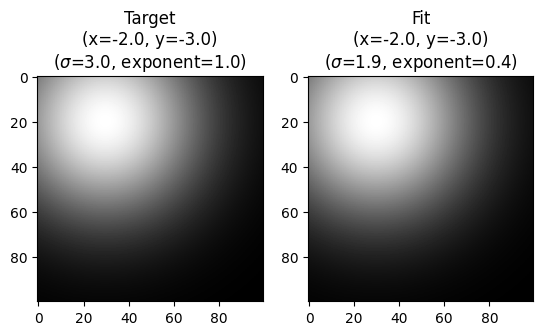

In [279]:
# make an x, y grid for computing gaussian
xGrid, yGrid = np.meshgrid(np.linspace(-5,5,100),np.linspace(-5,5,100))
def pRFGaussianExponent(x,y,sigma,exponent,xGrid,yGrid):
  x = torch.pow(torch.tensor(xGrid)-x,2.0)
  y = torch.pow(torch.tensor(yGrid)-y,torch.tensor(2.0))
  z = torch.exp(-(x+y)/(torch.tensor(2.0)*torch.pow(sigma,torch.tensor(2.0))))
  z = torch.pow(z,exponent)
  return z

# set init values
xInit = 0.0;yInit = 0.0;sigmaInit = 1.0;exponentInit = 1.0;

# initialize tensors
x = torch.tensor(xInit, requires_grad=True)
y = torch.tensor(yInit, requires_grad=True);
sigma = torch.tensor(sigmaInit, requires_grad=True);
exponent = torch.tensor(exponentInit, requires_grad=True);

# compute target
targetX = -2;
targetY=-3;
targetSigma=3;
targetExponent=1;
target = pRFGaussianExponent(targetX,targetY,targetSigma,targetExponent,xGrid,yGrid)

# set learning rate
learningRate = 0.001

# now find best fitting parameters using gradient-descent
nEpochs = 50000
for iEpoch in range(nEpochs):
  # compute current fit  
  fit = pRFGaussianExponent(x,y,sigma,exponent,xGrid,yGrid)
  # compute loss
  loss = (target-fit).pow(2).sum()
  # compute gradients
  loss.backward()
  # turn off gradient tracking
  x.requires_grad = False;
  y.requires_grad = False;
  sigma.requires_grad = False;
  exponent.requires_grad = False;
  # update parameters
  x -= x.grad*learningRate
  y -= y.grad*learningRate
  sigma -= sigma.grad*learningRate
  exponent -= exponent.grad*learningRate
  # turn on gradient tracking
  x.grad = torch.tensor(0.0)
  y.grad = torch.tensor(0.0)
  sigma.grad = torch.tensor(0.0)
  exponent.grad = torch.tensor(0.0)
  x.requires_grad = True;
  y.requires_grad = True;
  sigma.requires_grad = True;
  exponent.required_grad = True;
  # break out if loss is not improving
  if loss < epsilon:
    break
  # print
  if iEpoch%5000==0:
    # print this loop
    print('[%i/%i] loss: %0.2f (x=%0.1f, y=%0.1f, sigma=%0.2f, exponent=%0.1f)'%(iEpoch,nEpochs,loss,x,y,sigma,exponent))

print('[Fit after %i epochs] loss: %f (x=%0.2f, y=%0.2f, sigma=%0.2f, exponent=%0.1f)'%(iEpoch+1,loss,model.x,model.y,model.sigma,model.exponent))
# display model and fit
plt.subplot(1,2,1)
plt.imshow(target.detach().numpy(),cmap='gray')
plt.title('Target\n(x=%0.1f, y=%0.1f)\n($\sigma$=%0.1f, exponent=%0.1f)'%(targetX,targetY,targetSigma,targetExponent))
plt.subplot(1,2,2)
plt.imshow(fit.detach().numpy(),cmap='gray')
plt.title('Fit\n(x=%0.1f, y=%0.1f)\n($\sigma$=%0.1f, exponent=%0.1f)'%(model.x,model.y,model.sigma,model.exponent))

Now doing the same, using the nn.Module class so that we can try the Adam optimizer

(pRFModel:Init) Initialized pRF model (x=0.00, y=0.00, sigma=1.00, exponent=1.0)
[1/50000] loss: 0.186323 (x=-0.05, y=-0.05, sigma=1.05, exponent=1.0)
[Fit after 178 epochs] loss: 0.000000 (x=-2.00, y=-3.00, sigma=1.94, exponent=0.4)


Text(0.5, 1.0, 'Fit\n(x=-2.0, y=-3.0)\n($\\sigma$=1.9, exponent=0.4)')

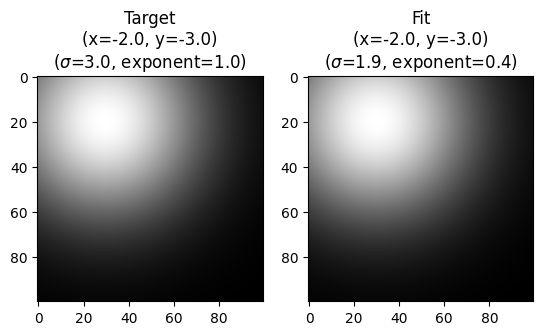

In [280]:
class pRFModel(nn.Module):
  def __init__(self,gridMin=-5,gridMax=5,gridSize=100,xInit=0.0,yInit=0.0,sigmaInit=1.0,exponentInit=1.0):
    # init the parent class
    super().__init__()
    # compute the grid
    xGrid, yGrid = np.meshgrid(np.linspace(gridMin,gridMax,gridSize),np.linspace(gridMin,gridMax,gridSize))
    # make them into tensors
    self.xGrid = torch.tensor(xGrid)
    self.yGrid = torch.tensor(yGrid)
    # initialize the parameters
    self.x = nn.Parameter(torch.tensor(xInit), requires_grad=True)
    self.y = nn.Parameter(torch.tensor(yInit), requires_grad=True);
    self.sigma = nn.Parameter(torch.tensor(sigmaInit), requires_grad=True);
    self.exponent = nn.Parameter(torch.tensor(exponentInit), requires_grad=True);
    print('(pRFModel:Init) Initialized pRF model (x=%0.2f, y=%0.2f, sigma=%0.2f, exponent=%0.1f)'%(self.x,self.y,self.sigma,self.exponent))
  def forward(self):
    # get x,y grid shifted to current x,y parameters
    x = torch.pow(self.xGrid-self.x,2.0)
    y = torch.pow(self.yGrid-self.y,2.0)
    # compute gaussian with sigma as standard deviation
    z = torch.exp(-(x+y)/(2.0*torch.pow(self.sigma,2.0)))
    # apply exponent
    z = torch.pow(z,self.exponent)
    return z

# compute target
targetX = -2;
targetY=-3;
targetSigma=3;
targetExponent=1;
target = pRFGaussianExponent(targetX,targetY,targetSigma,targetExponent,xGrid,yGrid)

# use mean squared error loss function
lossFunction = nn.MSELoss()

# init a pRF model
model = pRFModel()

# use adam optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.05)

# now find best fitting parameters using Adam optimizer
nEpochs = 50000
epsilon = 0.00000001
for iEpoch in range(nEpochs):
  # get the model fit
  fit = model.forward()
  # compute the loss
  loss = lossFunction(fit,target)
  # compute the gradients
  loss.backward()
  # and optimize
  optimizer.step()
  optimizer.zero_grad()
  # break out if loss is not improving
  if loss < epsilon:
    break
  # print
  if iEpoch%5000==0:
    print('[%i/%i] loss: %f (x=%0.2f, y=%0.2f, sigma=%0.2f, exponent=%0.1f)'%(iEpoch+1,nEpochs,loss,model.x,model.y,model.sigma,model.exponent))

print('[Fit after %i epochs] loss: %f (x=%0.2f, y=%0.2f, sigma=%0.2f, exponent=%0.1f)'%(iEpoch+1,loss,model.x,model.y,model.sigma,model.exponent))
# display model and fit
plt.subplot(1,2,1)
plt.imshow(target.detach().numpy(),cmap='gray')
plt.title('Target\n(x=%0.1f, y=%0.1f)\n($\sigma$=%0.1f, exponent=%0.1f)'%(targetX,targetY,targetSigma,targetExponent))
plt.subplot(1,2,2)
plt.imshow(fit.detach().numpy(),cmap='gray')
plt.title('Fit\n(x=%0.1f, y=%0.1f)\n($\sigma$=%0.1f, exponent=%0.1f)'%(model.x,model.y,model.sigma,model.exponent))